# Analysis of Looping Structure of Neural Embeddings


## Setup

In [ ]:
pip install numpy matplotlib hdbscan scipy

In [ ]:
# Libaries
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import scipy

In [ ]:
# Mount Drive to access files on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting Subsequences

In [ ]:
# Load a file
data = np.load('/content/drive/MyDrive/UO_BIRD/demoAudio1.npz')

emb = data['embVals']
startTimes = np.arange(len(emb[:,0]))*5/1000
print(startTimes)
dayVal = data['dayList']

[0.00000e+00 5.00000e-03 1.00000e-02 ... 2.04885e+02 2.04890e+02
 2.04895e+02]


In [ ]:
plt.figure(figsize=(40, 30))
plt.title('Orginal UMAP embedding')
plt.scatter(emb[:,0],emb[:,1],c = dayVal,alpha = .2)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

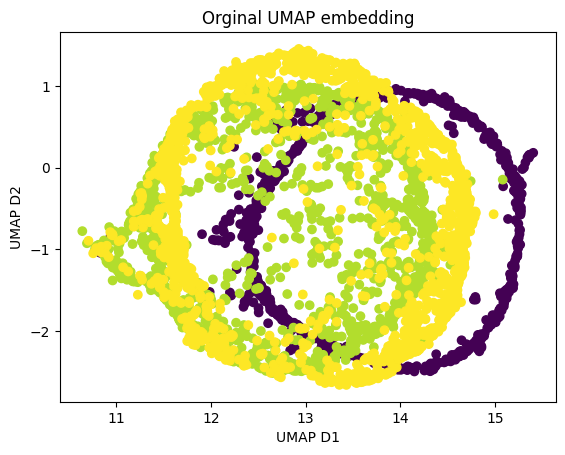

In [ ]:
distS = np.square((emb[:,0] - 13.5)) + np.square(emb[:,1] - .5)
foundInd = np.where(distS < 10)[0]

plt.title('Orginal UMAP embedding')
plt.scatter(emb[foundInd,0],emb[foundInd,1],c = dayVal[foundInd])
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

<ipython-input-48-c975e2a2737e>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


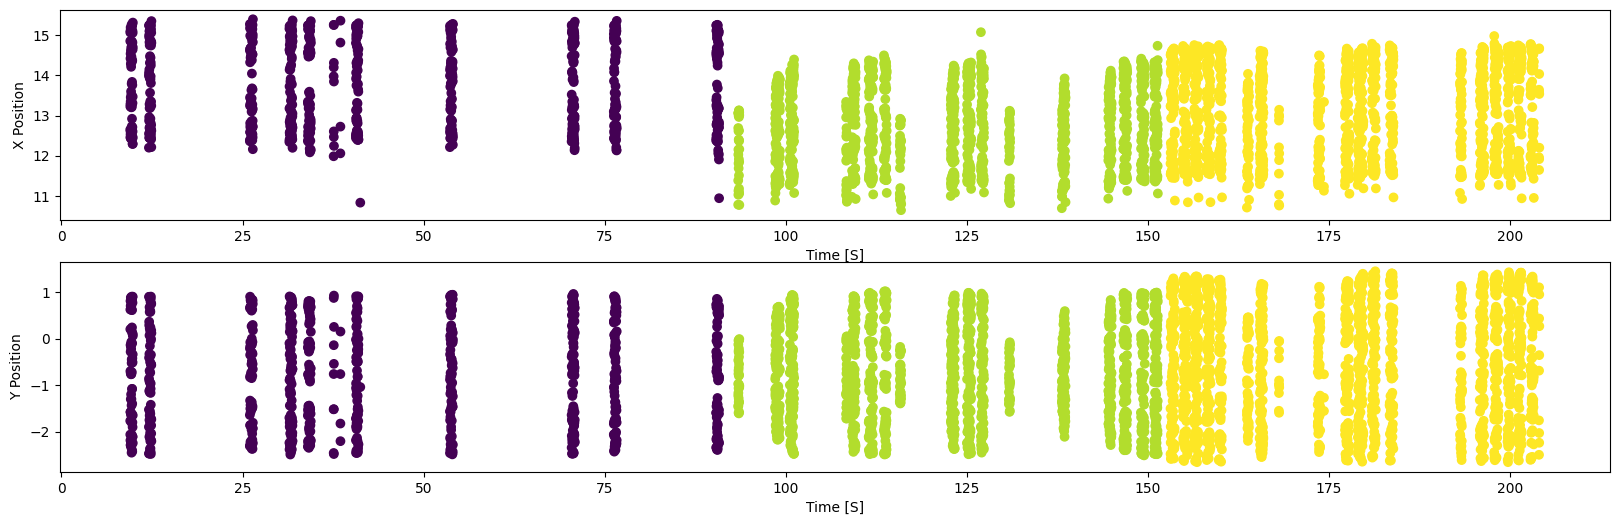

In [ ]:
fig = plt.figure(figsize=(20, 6))

plt.title('X and Y Coordinate of UMAP embedding')
plt.subplot(2,1,1)
plt.scatter(startTimes[foundInd],emb[foundInd,0],c = dayVal[foundInd])
plt.xlabel('Time [S]')
plt.ylabel('X Position')
plt.ylabel('X Position')
plt.subplot(2,1,2)
plt.scatter(startTimes[foundInd],emb[foundInd,1],c = dayVal[foundInd])
plt.xlabel('Time [S]')
plt.ylabel('Y Position')

plt.show()

<ipython-input-39-147f6c9de7a2>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


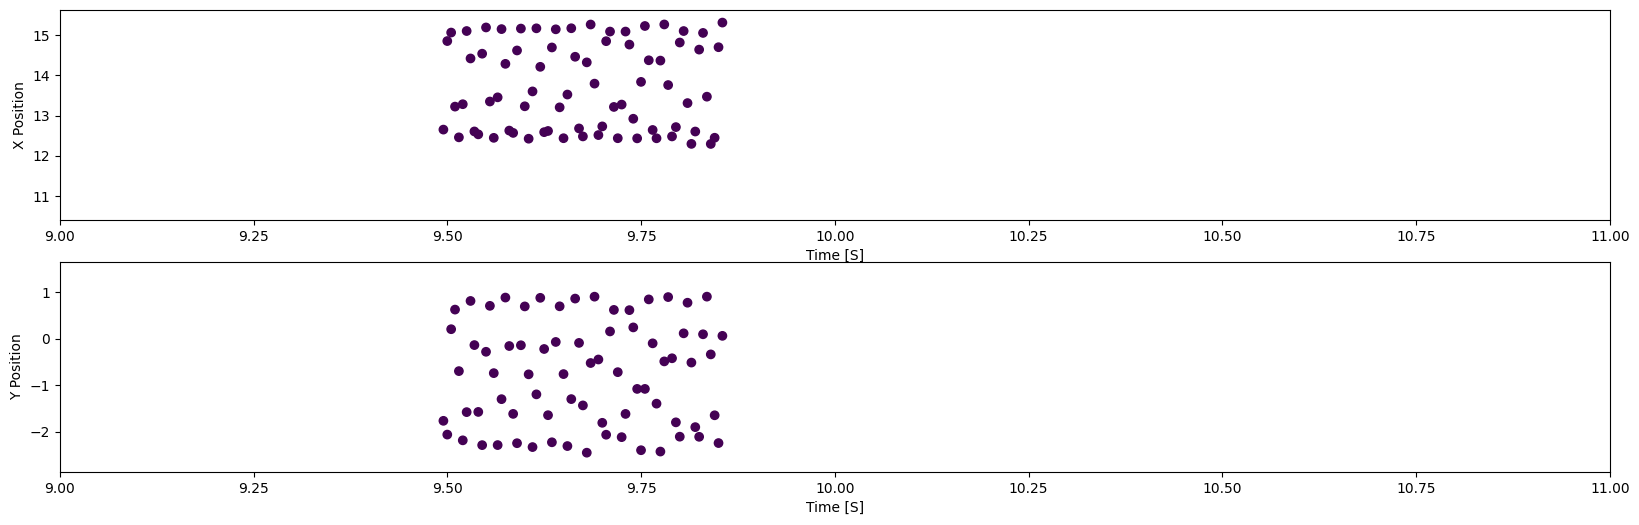

In [ ]:
fig = plt.figure(figsize=(20, 6))

plt.title('X and Y Coordinate of UMAP embedding')
plt.subplot(2,1,1)
plt.scatter(startTimes[foundInd],emb[foundInd,0],c = dayVal[foundInd])
plt.xlabel('Time [S]')
plt.ylabel('X Position')
plt.ylabel('X Position')
plt.xlim([9,11])

plt.subplot(2,1,2)
plt.scatter(startTimes[foundInd],emb[foundInd,1],c = dayVal[foundInd])
plt.xlabel('Time [S]')
plt.ylabel('Y Position')
plt.xlim([9,11])
plt.show()

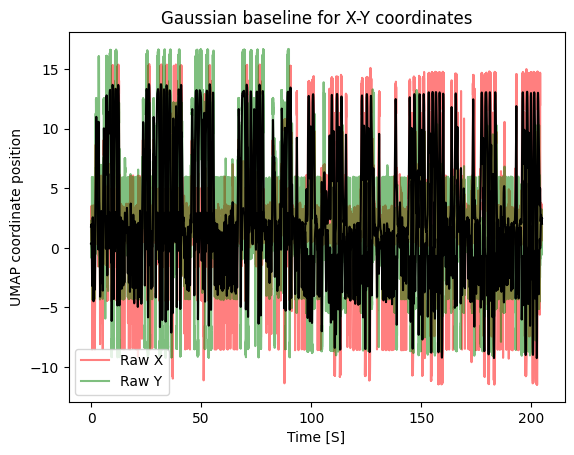

In [ ]:
from scipy.ndimage import gaussian_filter1d


rawX = emb[:,0]
rawY = emb[:,1]

M = 20
BLX = gaussian_filter1d(rawX, M) #np.convolve(rawY, np.ones(M)/M, mode='same')#np.convolve(rawX, np.ones(M)/M, mode='same')
BLY = gaussian_filter1d(rawY, M) #np.convolve(rawY, np.ones(M)/M, mode='same')
BCX = rawX - BLX
BCY = rawY - BLY

plt.title('Gaussian baseline for X-Y coordinates')
plt.plot(startTimes,rawX,color = 'r', label = 'Raw X',alpha = .5)
plt.plot(startTimes,rawY,color = 'g',label = 'Raw Y',alpha = .5)
plt.plot(startTimes,BLX,color = 'k')
plt.plot(startTimes,BLY,color = 'k')
plt.xlabel('Time [S]')
plt.ylabel('UMAP coordinate position')
plt.legend()
plt.show()


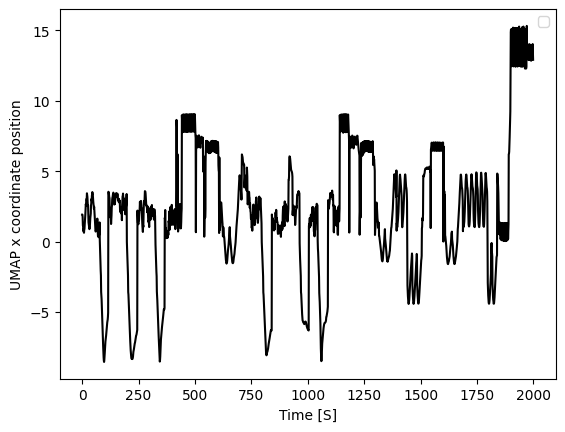

In [ ]:


rawX = emb[0:2000,0]
rawY = emb[0:2000,0]
plt.plot(rawX,color = 'k')
plt.xlabel('Time [S]')
plt.ylabel('UMAP x coordinate position')
plt.legend()
plt.show()

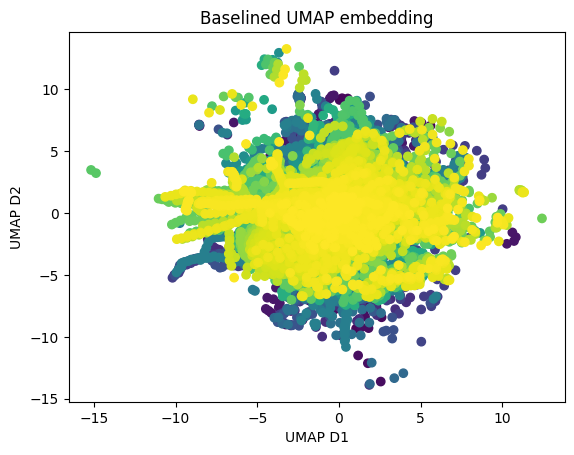

In [ ]:
plt.title('Baselined UMAP embedding')
plt.scatter(BCX,BCY,c = startTimes)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

In [ ]:
# Calc running polar
naiveTheta = np.arctan2(BCY, BCX)
radiusArr = np.sqrt(np.square(BCX) + np.square(BCY))
angleCuttoff = -6

modTheta = naiveTheta.copy()
modTheta[0] = naiveTheta[0]
for i in range(1,len(naiveTheta)):
  angleDiff = naiveTheta[i] - naiveTheta[i-1]
  if angleDiff < angleCuttoff:
    modTheta[i] = modTheta[i-1] + angleDiff + 2*np.pi
  else:
    modTheta[i] =  modTheta[i-1] + angleDiff

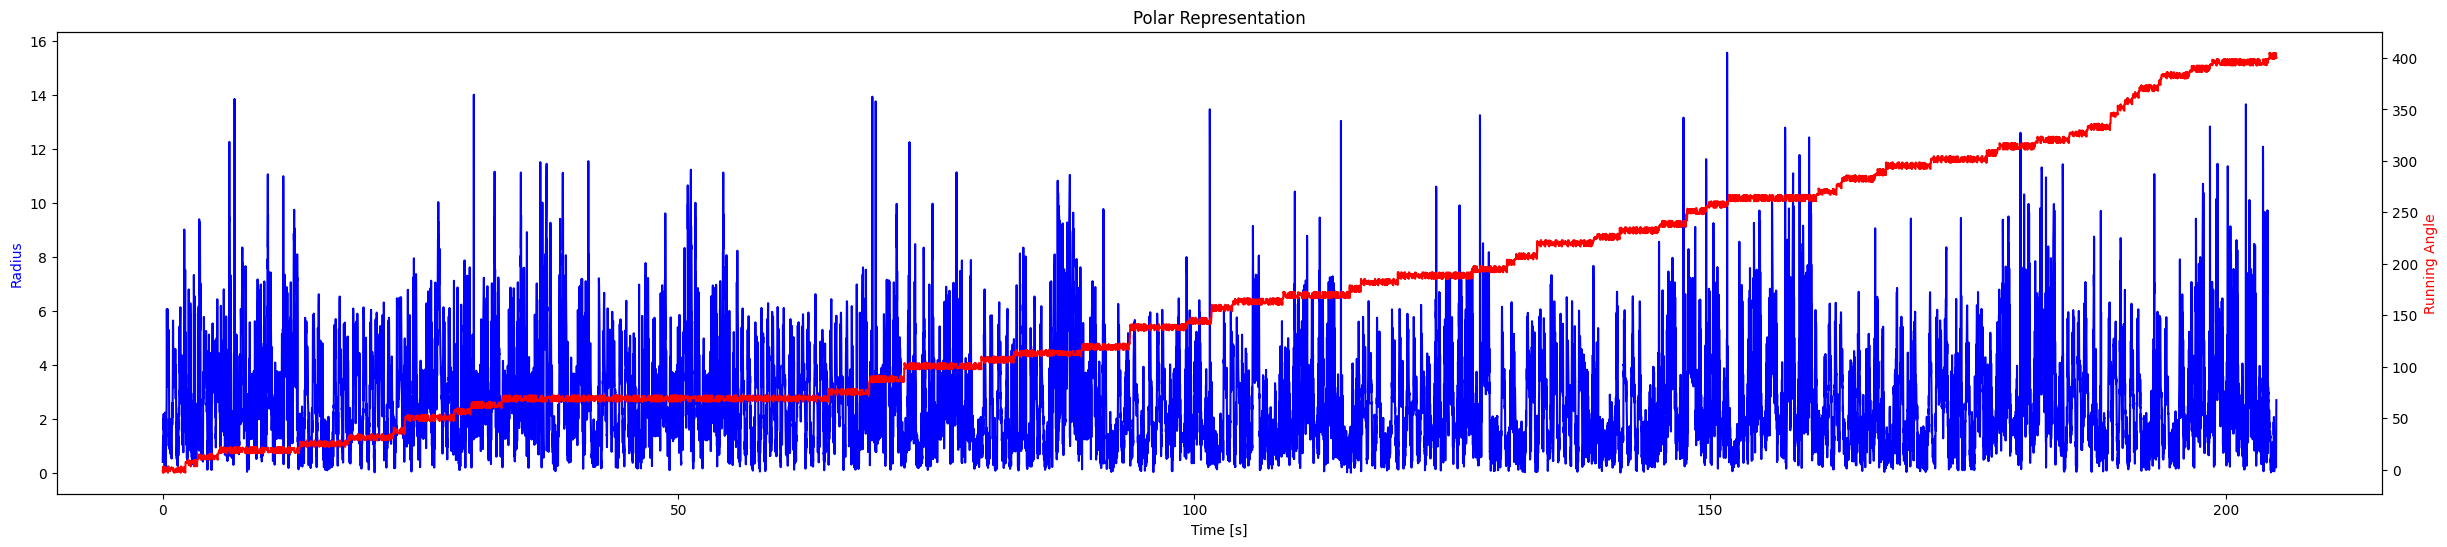

In [ ]:
# Display Polar
fig, ax1 = plt.subplots(figsize=(30, 6))

plt.title('Polar Representation')
ax1.plot(startTimes,radiusArr, color='blue')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Radius', color='blue')

ax2 = ax1.twinx()
ax2.plot(startTimes, modTheta, color='red')
ax2.set_ylabel('Running Angle', color='red')

plt.show()


In [ ]:
# Revise w/ min length
def find_subarrays(arr, polarity):
    subarrays = []
    start = 0

    for end in range(1, len(arr)):
        if polarity * arr[end] > polarity * arr[end - 1]:
            continue
        if start < end - 1:
            subarrays.append((start, end - 1))
        start = end

    if start < len(arr) - 1:
        subarrays.append((start, len(arr) - 1))

    return subarrays


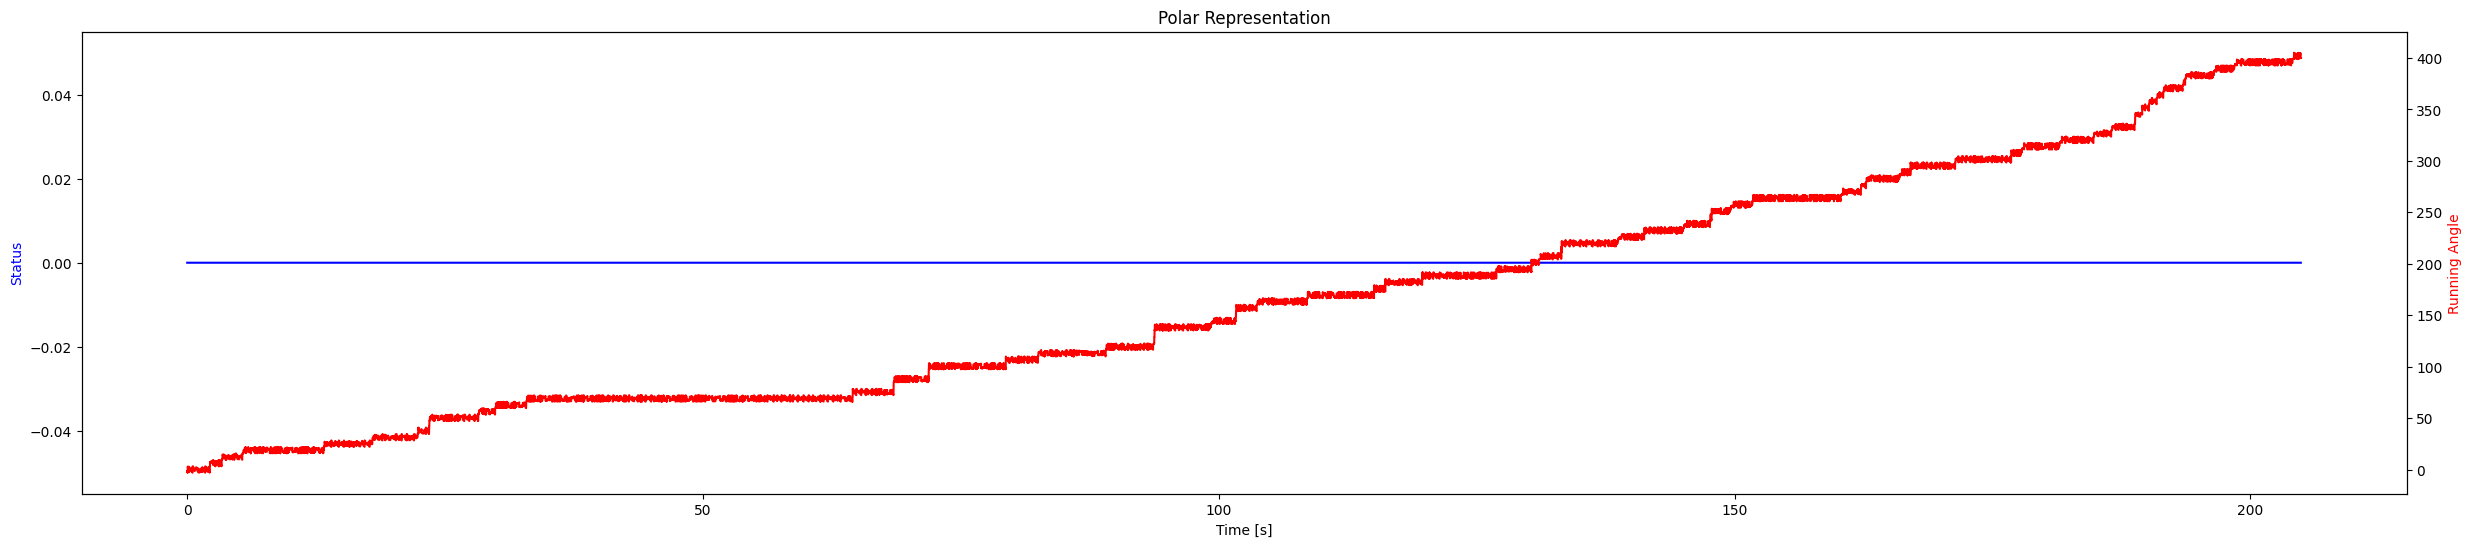

In [ ]:
# Calculate monotonic periods of increasing and decreasing
increasing_subarrays_corrected_theta = find_subarrays(modTheta,1)
decreasing_subarrays_corrected_theta = find_subarrays(modTheta,-1)

additiveArr = increasing_subarrays_corrected_theta + decreasing_subarrays_corrected_theta
embCentered = emb.copy()

timeInd = np.arange(len(startTimes))
statusArr = np.zeros_like(startTimes)

cutoffAngle = np.pi*2
cutoffLength = 80

validLoops = list()
for start,end in additiveArr:
  diffAngle = modTheta[end] - modTheta[start]
  if np.abs(diffAngle) > cutoffAngle and end - start > cutoffLength: #todo pi
    statusArr[start:end] = 1
    validLoops.append((start,end))

    aveRad = np.median(radiusArr[start:end])
    randLength = end - start
    randNoise1 = np.random.normal(0, aveRad/3, randLength)
    randNoise2 = np.random.normal(0, aveRad/3, randLength)
    #print(randNoise)
    embCentered[start:end,0] = np.mean(emb[start:end,0]) + randNoise1
    embCentered[start:end,1] = np.mean(emb[start:end,1]) + randNoise2


# Display Polar
fig, ax1 = plt.subplots(figsize=(30, 6))

plt.title('Polar Representation')
ax1.plot(startTimes,statusArr, color='blue')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Status', color='blue')

ax2 = ax1.twinx()
ax2.plot(startTimes, modTheta, color='red')
ax2.set_ylabel('Running Angle', color='red')

plt.show()


In [ ]:
#HDBSCAN
import hdbscan
def makeClusters(data,min_cluster_size = 10):
	clusterer = hdbscan.HDBSCAN(metric='euclidean',min_cluster_size=min_cluster_size)
	clusterer.fit(data)
	return clusterer.labels_

statusOne = np.where(statusArr == 1)[0]

labels = makeClusters(embCentered[statusOne,:])

plt.title('Selected UMAP embedding')
plt.scatter(emb[statusOne,0],emb[statusOne,1],c = labels,s = .1)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

ValueError: ignored

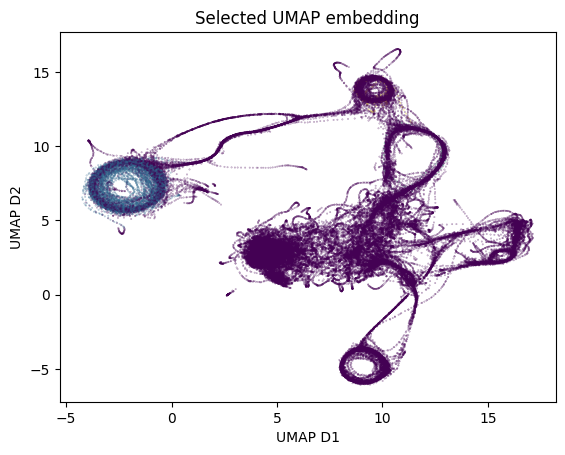

In [ ]:

classArr = np.zeros_like(statusArr)
classArr[statusOne] = labels + 1


plt.title('Selected UMAP embedding')
plt.scatter(emb[:,0],emb[:,1],c = classArr,alpha = .5,s = .1)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

In [ ]:
# Now get angles

masterOutput = dict()
for index in np.unique(classArr):
  name = f'Loop{int(index)}'
  masterOutput[name] = list()
  #print(name)


masterOutput['Loop1'].append(1)

for start,end in validLoops:
  classFound = np.median(classArr[start:end])
  diffAngle = modTheta[end] - modTheta[start]
  loopNum = diffAngle/(2*np.pi)
  name = f'Loop{int(classFound)}'

  #print(f'Loop{classFound} found with {loopNum} loops')

  masterOutput[name].append(loopNum)

masterOutput



{'Loop0': [],
 'Loop1': [1,
  6.041071005136387,
  5.9360852298779925,
  10.309102614112021,
  3.9298006412766022,
  4.113957112370375,
  7.107685488484103,
  4.057460216067735,
  4.0163212277868405,
  4.970502904733105,
  12.996938084389077,
  7.042169099709488,
  3.9065816408661163,
  3.004127263234081,
  4.0242964602257105,
  4.2536159634953865,
  6.977735827155255,
  3.0647817715754995,
  6.110932001351056,
  4.337963032029744,
  8.294572014016666,
  3.673502801477265,
  6.052162018092635,
  3.6601557011471706,
  5.0139635502038775,
  3.005681510725213,
  4.836274205780236,
  4.086369219402786,
  5.970078322467238,
  3.2571587547903365,
  5.980122646878677,
  3.24113057753804,
  3.093069075914098,
  2.890550627819626,
  3.0111213769441743,
  5.901594292389243,
  5.070615871255631,
  11.078442979663732,
  7.982653970640154,
  2.962978560906367,
  3.0935742063487157,
  9.04369987664855,
  9.23188039163733,
  7.018865101389331,
  5.224836078563183,
  4.029425476946445,
  3.19246320297

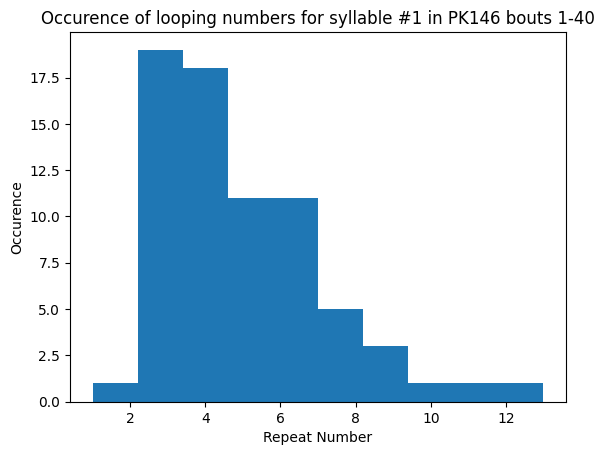

In [ ]:
countsDemo = masterOutput['Loop1']

plt.title('Occurence of looping numbers for syllable #1 in PK146 bouts 1-40')
plt.hist(countsDemo,bins = 10)
plt.xlabel('Repeat Number')
plt.ylabel('Occurence')
plt.show()


# establish true center, and test looping of entire group post clustering, then release the cutoff metric and define neighborhood/track, then use polar window about true cetner

# Reccurence stuff


(79833, 2)


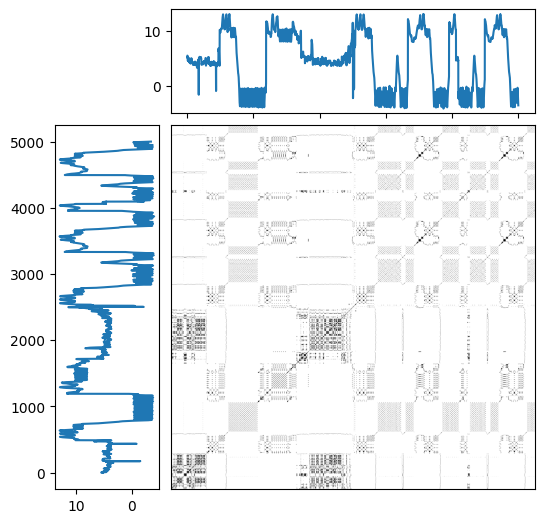

In [ ]:
from pyts.datasets import load_gunpoint
from pyts.image import RecurrencePlot


# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot


x = emb[0:5000,0]
print(emb.shape)
time_points = np.arange(len(x))



# Create a toy time series using the sine function
# time_points = np.linspace(0, 4 * np.pi, 1000)
# x = np.sin(time_points)
X = np.array([x])

# Recurrence plot transformation
rp = RecurrencePlot(threshold=np.pi/18)
X_rp = rp.transform(X)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))
# plt.imshow(X_rp[0], cmap='binary', origin='lower')
# plt.show()
gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Define the ticks and their labels for both axes
# time_ticks = np.linspace(0, 4 * np.pi, 9)
# time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
#                    r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
#                    r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
# value_ticks = [-1, 0, 1]
# reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
# ax_left.set_xticks(reversed_value_ticks)
# ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
# ax_left.set_yticks(time_ticks)
# ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(time_points, x)
# ax_top.set_xticks(time_ticks)
# ax_top.set_xticklabels(time_ticklabels)
# ax_top.set_yticks(value_ticks)
# ax_top.set_yticklabels(value_ticks)
# ax_top.xaxis.tick_top()

# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
             extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.show()

(1, 5000, 5000)


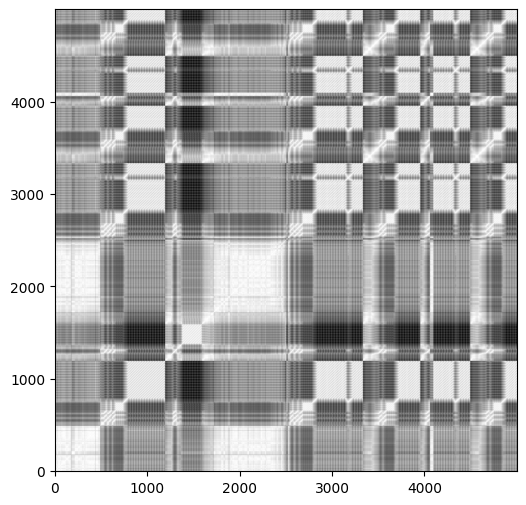

In [ ]:
x = emb[0:5000,0]
y = emb[0:5000,1]

time_points = np.arange(len(x))



X = np.array([x])
Y = np.array([y])
# Recurrence plot transformation
rp = RecurrencePlot()
X_rp = rp.transform(X)
Y_rp = rp.transform(Y)

new = X_rp + Y_rp
print(X_rp.shape)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))
plt.imshow(new[0], cmap='binary', origin='lower')
plt.show()

In [ ]:
pip install

In [ ]:
pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.9 MB/s eta 0:00:00
